In [1]:
!wget https://github.com/nenaiko-dareda/OSAKA_Univ/blob/main/PE-samples.zip?raw=true -O PE-samples.zip

--2025-12-16 06:16:56--  https://github.com/nenaiko-dareda/OSAKA_Univ/blob/main/PE-samples.zip?raw=true
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/nenaiko-dareda/OSAKA_Univ/raw/refs/heads/main/PE-samples.zip [following]
--2025-12-16 06:16:56--  https://github.com/nenaiko-dareda/OSAKA_Univ/raw/refs/heads/main/PE-samples.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/nenaiko-dareda/OSAKA_Univ/refs/heads/main/PE-samples.zip [following]
--2025-12-16 06:16:56--  https://raw.githubusercontent.com/nenaiko-dareda/OSAKA_Univ/refs/heads/main/PE-samples.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.108.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185

In [2]:
!unzip -q "PE-samples.zip"

In [3]:
!pip install pefile

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 kB 2.8 MB/s eta 0:00:00


In [4]:
import glob
import pefile
import pandas as pd

# ラベルと特徴量に使用するPEメタデータのリスト
features=["malware","DebugSize","ImageVersion","IatRVA","ExportSize","ResourceSize",\
                               "VirtualSize2","NumberOfSections"]

def extract_feature(fpath):
    data_list = []

    files = glob.glob(fpath)
    for file in files:
        print(file)
        try:
            data = pefile.PE(file)

            DS = data.OPTIONAL_HEADER.DATA_DIRECTORY[6].Size
            IV = data.OPTIONAL_HEADER.MajorImageVersion
            IatRVA = data.OPTIONAL_HEADER.DATA_DIRECTORY[1].VirtualAddress
            ES = data.OPTIONAL_HEADER.DATA_DIRECTORY[0].Size
            RS = data.OPTIONAL_HEADER.DATA_DIRECTORY[2].Size

            VS2 = data.sections[1].Misc_VirtualSize
            NS = data.FILE_HEADER.NumberOfSections

            data_list.append({
                "malware": 0,
                "DebugSize": DS,
                "ImageVersion": IV,
                "IatRVA": IatRVA,
                "ExportSize": ES,
                "ResourceSize": RS,
                "VirtualSize2": VS2,
                "NumberOfSections": NS
            })

        except Exception as e:
          print(e)

    return pd.DataFrame(data_list, columns=features)

df = pd.DataFrame(columns=features)

PATH = ['/content/PE-samples/*.exe']
all_dfs = []

for path in PATH:
    print(f"Scanning path: {path}")
    new_df = extract_feature(path)
    if not new_df.empty:
        all_dfs.append(new_df)

if all_dfs:
    final_df = pd.concat(all_dfs, ignore_index=True)
    final_df.to_csv('sample.csv', index=False)
    print("Saved to sample.csv")
else:
    print("No data extracted.")

Scanning path: /content/PE-samples/*.exe
/content/PE-samples/ConsoleApplication1.exe
/content/PE-samples/Server.exe
/content/PE-samples/TestApp.exe
/content/PE-samples/TCPClient.exe
/content/PE-samples/base64test.exe
Saved to sample.csv


In [5]:
df.head()

,malware,DebugSize,ImageVersion,IatRVA,ExportSize,ResourceSize,VirtualSize2,NumberOfSections


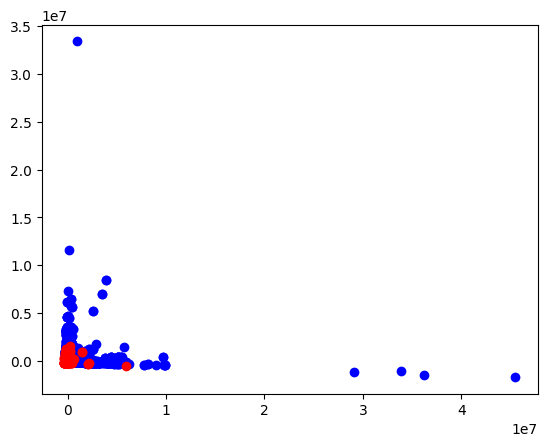

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

df = pd.read_csv('/content/PE-samples/malware.csv', index_col=False)
df2 = pd.read_csv('/content/PE-samples/benign.csv', index_col=False)

#PCAによる次元削減
X_reduced = PCA(n_components=2).fit_transform(df.iloc[:,2:])
Y_reduced = PCA(n_components=2).fit_transform(df2.iloc[:,2:])

plt.scatter(Y_reduced[:, 0], Y_reduced[:, 1], c="blue")
plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c="red")

plt.show()

In [7]:
df2.tail()

,Unnamed: 0,malware,DebugSize,ImageVersion,IatRVA,ExportSize,ResourceSize,VirtualSize2,NumberOfSections
10754,10754,0,56,0,69104,125,1160,42198,5
10755,10755,0,56,0,285500,123,1064,148894,5
10756,10756,0,56,0,36464,128,1184,15038,5
10757,10757,0,56,0,40548,129,1184,21494,5
10758,10758,0,0,0,28372,130,0,11546,5


In [8]:
!head /content/PE-samples/union.csv

,malware,DebugSize,ImageVersion,IatRVA,ExportSize,ResourceSize,VirtualSize2,NumberOfSections
0,1,0,6,34100,0,18720,4946,5
1,1,0,0,36060,0,272008,272008,3
2,1,0,0,225608,0,16084,16084,3
3,1,0,1,126976,0,1479216,1124,9
4,1,0,0,232060,0,290048,290048,3
5,1,0,0,55232,0,147440,147440,3
6,1,27,0,138100,0,1888,15880,4
7,1,0,0,490740,0,1024,1024,3
8,1,0,0,499712,0,275036,29452,8


In [9]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

df = pd.read_csv('/content/PE-samples/union.csv')
test_df = pd.read_csv('/content/PE-samples/test2.csv')

df=df.drop('Unnamed: 0', axis=1)
test_df=test_df.drop('Unnamed: 0', axis=1)

In [10]:
test_df

,malware,DebugSize,ImageVersion,IatRVA,ExportSize,ResourceSize,VirtualSize2,NumberOfSections
0,1,28,0,9120,0,0,1244,4
1,1,0,6,34100,0,18720,4946,5
2,1,0,0,343808,0,112800,58794,4
3,1,0,0,36060,0,272008,272008,3
4,1,0,0,225608,0,16084,16084,3
...,...,...,...,...,...,...,...,...
354,1,0,0,58760,0,3968,2614,4
355,1,0,0,565248,0,151092,7076,8
356,1,0,0,8272,0,535512,472,5
357,1,0,0,221444,0,184,11090,5


In [11]:
clf_k = KNeighborsClassifier(n_neighbors=3)
clf_k.fit(df.iloc[:,1:], df.iloc[:,0])

output = clf_k.predict(test_df.iloc[:,1:])

for i in output:
    if i == 0:
        print("not malware")
    elif i == 1:
        print("malware")

not malware
not malware
not malware
malware
malware
malware
not malware
not malware
not malware
not malware
malware
not malware
not malware
not malware
not malware
malware
malware
malware
not malware
malware
malware
not malware
not malware
malware
not malware
malware
not malware
not malware
not malware
not malware
not malware
malware
not malware
not malware
not malware
not malware
malware
not malware
not malware
not malware
not malware
malware
not malware
not malware
malware
not malware
not malware
not malware
not malware
malware
malware
not malware
not malware
malware
not malware
not malware
malware
malware
malware
not malware
not malware
not malware
malware
malware
not malware
not malware
not malware
not malware
malware
not malware
not malware
not malware
not malware
malware
not malware
malware
not malware
not malware
not malware
malware
not malware
not malware
malware
malware
not malware
not malware
not malware
not malware
malware
not malware
not malware
malware
malware
malware
malw

In [13]:
from sklearn.metrics import accuracy_score
accuracy_score(test_df.iloc[:,0], output)

0.35376044568245124

In [14]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

for i in range(1,20):
  clf_k = KNeighborsClassifier(n_neighbors=i)
  clf_k.fit(df.iloc[:,1:], df.iloc[:,0])
  output = clf_k.predict(test_df.iloc[:,1:])
  print("n_neighbors={0} {1}".format(i, accuracy_score(test_df.iloc[:,0], output)))

n_neighbors=1 0.46518105849582175
n_neighbors=2 0.35097493036211697
n_neighbors=3 0.35376044568245124
n_neighbors=4 0.22284122562674094
n_neighbors=5 0.233983286908078
n_neighbors=6 0.19498607242339833
n_neighbors=7 0.20055710306406685
n_neighbors=8 0.15877437325905291
n_neighbors=9 0.16434540389972144
n_neighbors=10 0.15041782729805014
n_neighbors=11 0.15041782729805014
n_neighbors=12 0.12534818941504178
n_neighbors=13 0.14206128133704735
n_neighbors=14 0.13370473537604458
n_neighbors=15 0.13370473537604458
n_neighbors=16 0.12256267409470752
n_neighbors=17 0.12534818941504178
n_neighbors=18 0.11977715877437325
n_neighbors=19 0.12256267409470752


In [15]:
from sklearn import svm

clf_svm = svm.SVC(gamma="scale")
clf_svm.fit(df.iloc[:,1:], df.iloc[:,0])
output_svm = clf_svm.predict(test_df.iloc[:,1:])

accuracy_score(test_df.iloc[:,0], output_svm)

0.0

## 精度改善モデルの作成

In [16]:
#決定木モデル
from sklearn.tree import DecisionTreeClassifier
dtc = DecisionTreeClassifier(criterion="gini", max_depth=15, random_state=42)
dtc.fit(df.iloc[:,1:], df.iloc[:,0])
output_dtc = dtc.predict(test_df.iloc[:,1:])
accuracy_score(test_df.iloc[:,0], output_dtc)

0.6434540389972145

In [17]:
#ランダムフォレスト
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42)
rfc.fit(df.iloc[:,1:], df.iloc[:,0])
output_rfc = rfc.predict(test_df.iloc[:,1:])
accuracy_score(test_df.iloc[:,0], output_rfc)

0.6239554317548747

In [18]:
#XGboost
from xgboost import XGBClassifier
xgb = XGBClassifier(n_estimators=100, max_depth=15, random_state=42)
xgb.fit(df.iloc[:,1:], df.iloc[:,0])
output_xgb = xgb.predict(test_df.iloc[:,1:])
accuracy_score(test_df.iloc[:,0], output_xgb)

0.6657381615598886

## 汎化性能の確認手段

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[classification report]
               precision    recall  f1-score   support

 not malware       0.00      0.00      0.00         0
     malware       1.00      0.67      0.80       359

    accuracy                           0.67       359
   macro avg       0.50      0.33      0.40       359
weighted avg       1.00      0.67      0.80       359

Confusion Matrix:


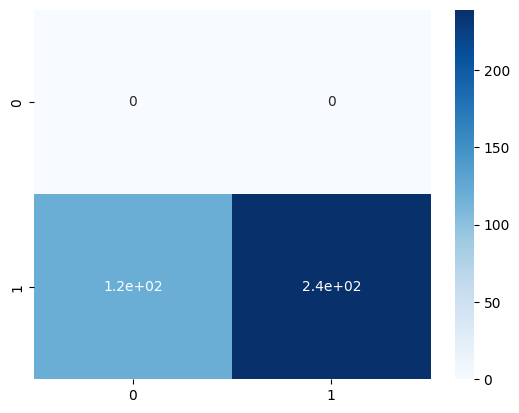

In [19]:
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

report = classification_report(test_df.iloc[:,0], output_xgb, target_names=['not malware', 'malware'])
print("[classification report]\n",report)

conf_matrix = confusion_matrix(test_df.iloc[:,0], output_xgb)
print("Confusion Matrix:")
sns.heatmap(conf_matrix, annot=True, cmap='Blues')
plt.show()

## 過学習を防ぐ手法

In [21]:
%pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 404.7/404.7 kB 21.5 MB/s eta 0:00:00


In [31]:
import optuna
def objective(trial):
    reg_lambda = trial.suggest_float('reg_lambda', 0.0, 1.5, log=False)

    model = XGBClassifier(
        n_estimators=100,
        max_depth=15,
        reg_lambda=reg_lambda,
        random_state=42,
        n_jobs=-1
    )

    model.fit(df.iloc[:,1:], df.iloc[:,0])

    pred = model.predict(test_df.iloc[:,1:])
    accuracy = accuracy_score(test_df.iloc[:,0], pred)

    return accuracy

In [35]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)
print(f"reg_lambda : {study.best_params['reg_lambda']:.4f}")

[I 2025-12-16 06:59:37,073] A new study created in memory with name: no-name-dae6a71b-0643-4b58-a034-d3377e5efb99
[I 2025-12-16 06:59:37,185] Trial 0 finished with value: 0.6545961002785515 and parameters: {'reg_lambda': 0.4736807919631564}. Best is trial 0 with value: 0.6545961002785515.
[I 2025-12-16 06:59:37,296] Trial 1 finished with value: 0.6629526462395543 and parameters: {'reg_lambda': 0.034116560692906084}. Best is trial 1 with value: 0.6629526462395543.
[I 2025-12-16 06:59:37,414] Trial 2 finished with value: 0.6796657381615598 and parameters: {'reg_lambda': 1.4961056987046752}. Best is trial 2 with value: 0.6796657381615598.
[I 2025-12-16 06:59:37,763] Trial 3 finished with value: 0.6685236768802229 and parameters: {'reg_lambda': 0.9373007669041986}. Best is trial 2 with value: 0.6796657381615598.
[I 2025-12-16 06:59:38,398] Trial 4 finished with value: 0.6685236768802229 and parameters: {'reg_lambda': 1.0056176281235092}. Best is trial 2 with value: 0.6796657381615598.
[I 2

reg_lambda : 0.5719


In [36]:
xgb = XGBClassifier(n_estimators=100, max_depth=15, reg_lambda=0.5719, random_state=42)
xgb.fit(df.iloc[:,1:], df.iloc[:,0])
output_xgb = xgb.predict(test_df.iloc[:,1:])
accuracy_score(test_df.iloc[:,0], output_xgb)

0.6991643454038997

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


[classification report]
               precision    recall  f1-score   support

 not malware       0.00      0.00      0.00         0
     malware       1.00      0.70      0.82       359

    accuracy                           0.70       359
   macro avg       0.50      0.35      0.41       359
weighted avg       1.00      0.70      0.82       359

Confusion Matrix:


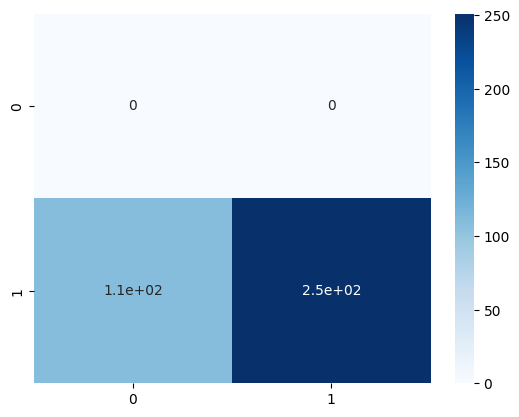

In [37]:
report = classification_report(test_df.iloc[:,0], output_xgb, target_names=['not malware', 'malware'])
print("[classification report]\n",report)

conf_matrix = confusion_matrix(test_df.iloc[:,0], output_xgb)
print("Confusion Matrix:")
sns.heatmap(conf_matrix, annot=True, cmap='Blues')
plt.show()